In [117]:
from generator import Generator, load_rgb_img, show_image
from ImageTransformationNN import ImageTransformationNN
from VGG16 import VGG16LossNN

import torch, time, argparse, os

from torch.optim import Adam
from torch.nn import MSELoss

from torchvision import transforms

from torch.autograd import set_detect_anomaly, Variable

from torchsummary import summary
import numpy as np

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
torch.cuda.is_available()

True

In [120]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [121]:
# To be moved to utils.py

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def normalize_batch(batch):
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch = batch.sub(Variable(mean).cuda())
    return batch

def preprocess(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [122]:
ALI_DATA_DIR=r"/content/drive/MyDrive/Coco/Train_images_1/"
ALI_STYLE_DIR=r"/content/drive/MyDrive/Coco/styles/"
ALI_STYLE_PATH = f"{ALI_STYLE_DIR}/0tf5En-Az5k.jpeg"
BATCH_SIZE = 4
DIM = 256

In [123]:
# Parser: Temporarily disabled for jupyter notebook
"""parser = argparse.ArgumentParser(description='Arguments for the network.')

parser.add_argument('learning_rate', type=float,
                    help='Learning rate')

parser.add_argument('epochs', type=int,
                    help='Number of epochs')

parser.add_argument('content_weights', type=int,
                    help='Content weights')

parser.add_argument('log_interval', type=int,
                    help='Integer for Log interval')

parser.add_argument('checkpoint_model_dir', type=str,
                    help='Path for checkpoints directory')  

parser.add_argument('checkpoint_interval', type=int,
                    help='Integer for checkpoints interval') 

args = parser.parse_args()"""

"parser = argparse.ArgumentParser(description='Arguments for the network.')\n\nparser.add_argument('learning_rate', type=float,\n                    help='Learning rate')\n\nparser.add_argument('epochs', type=int,\n                    help='Number of epochs')\n\nparser.add_argument('content_weights', type=int,\n                    help='Content weights')\n\nparser.add_argument('log_interval', type=int,\n                    help='Integer for Log interval')\n\nparser.add_argument('checkpoint_model_dir', type=str,\n                    help='Path for checkpoints directory')  \n\nparser.add_argument('checkpoint_interval', type=int,\n                    help='Integer for checkpoints interval') \n\nargs = parser.parse_args()"

In [127]:
class StyleTransferTrainer(object):
    
    def __init__(self, DATA_DIR, STYLE_PATH, BATCH_SIZE):
        self.loss_net = VGG16LossNN().cuda()
        self.transformer = ImageTransformationNN().cuda()
        self.transformer.load_state_dict(torch.load('/content/drive/MyDrive/style_save/style2/checkpoints_style2/check_epoch_1batch_id2160.pth'))
        print('Loaded weights successfully ')
        self.gen = Generator(DATA_DIR, BATCH_SIZE)
        print('Loaded images successfully')
        self.style = load_rgb_img(STYLE_PATH)
    
    def train(self):
        
        # Parameters ( to be placed in parser )
        learning_rate = 1e-3 
        epochs = 2
        content_weights = 1
        style_weights = 5
        log_interval = 1
        checkpoint_model_dir = '/content/drive/MyDrive/style_save/checkpoints_style2'
        checkpoint_interval = 20
        #! 
        
        optimizer = Adam(self.transformer.parameters(), learning_rate)

        mse_loss = MSELoss()

        style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
        ])
        
        style = style_transform(self.style)
        style = style.repeat(BATCH_SIZE, 1, 1, 1)
        style = preprocess(style).cuda()
        
        loss_net_input = normalize_batch(style)
        
        feature_style = self.loss_net.forward(normalize_batch(style))
        gram_style = [gram_matrix(y) for y in feature_style.values()]
    
        l_total_history, l_feat_history, l_style_history = [], [], []
        l_feat_total_history, l_style_total_history, l_total_total_history = [], [], []     
                 
        for epoch in range(epochs):
          
            print('epoch:', epoch)
            self.transformer.train()
            #print('-------------\n', self.transformer, '\n-------------')

            l_feat_total = 0.
            l_style_total = 0.
            count = 0

            # To revise
            for batch_id, (x, _) in enumerate(self.gen):

                # Add the batch size
                n_batch = len(x)
                count += n_batch

                # Adam
                optimizer.zero_grad()

                # Preprocess:
                x = Variable(preprocess(x)).cuda()

                # Feed x to transformer
                y = self.transformer(x)
                    
                xc = Variable(x.clone())

                # Normalize batch
                y = normalize_batch(y)
                xc = normalize_batch(xc)

                # Features from the VGG16 network
                features_y = self.loss_net(y)
                features_xc = self.loss_net(xc)
                    
                f_xc_c = Variable(features_xc['relu2_2'], requires_grad=False)

                # Update features reconstruction loss
                mse = mse_loss(features_y['relu2_2'], f_xc_c)

                l_feat = content_weights * mse

                l_style = 0.
                    
                
                for m, k in enumerate(features_y.keys()):
                    gram_s = Variable(gram_style[m].data, requires_grad=False)
                    gram_y = gram_matrix(features_y[k])
                    l_style += style_weights * mse_loss(gram_y, gram_s[:n_batch, :, :])

                l_total = l_feat + l_style

                l_total.backward()
                optimizer.step()

                l_feat_total += l_feat.item()
                l_style_total += l_style.item()

                if (batch_id + 1) % 10 == 0:

                    # Saving losses per item
                    l_feat_history.append(l_feat.item())
                    l_style_history.append(l_style.item())
                    l_total_history.append(l_total.item())

                    # Total
                    l_feat_total_history.append(l_feat_total / (batch_id + 1))
                    l_style_total_history.append(l_style_total / (batch_id + 1))
                    l_total_total_history.append((l_feat_total + l_style_total) / (batch_id + 1))

                if (batch_id + 1) % log_interval == 0:
                    summary = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                        time.ctime(), epoch + 1, count, len(self.gen.train),
                        l_feat_total / (batch_id + 1),
                        l_style_total / (batch_id + 1),
                        (l_feat_total + l_style_total) / (batch_id + 1))
                    print(summary)


                if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                    self.transformer.eval()
                    filename = "check_epoch_" + str(epoch) + "batch_id" + str(batch_id + 1) + '.pth'
                    path = os.path.join(checkpoint_model_dir, filename)
                    print('\nSaving model:', path, '\n')
                    torch.save(self.transformer.state_dict(), path)
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_total_history.csv", l_total_history, delimiter=",")
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_feat_history.csv", l_feat_history, delimiter=",")
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_style_history.csv", l_style_history, delimiter=",")
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_total_total_history.csv", l_feat_total_history, delimiter=",")
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_feat_total_history.csv", l_feat_total_history, delimiter=",")
                    np.savetxt("/content/drive/MyDrive/style_save/losses_style2/l_style_total_history.csv", l_style_total_history, delimiter=",")
                    print('Model saved.')

        self.transformer.eval()
    


In [128]:
def main():
    
    #parser = argparse.ArgumentParser(description='Arguments for the training.')

    model = StyleTransferTrainer(ALI_DATA_DIR, ALI_STYLE_PATH, BATCH_SIZE)
    model.train()

In [129]:
main()

Streaming output truncated to the last 5000 lines.
Saving model: /content/drive/MyDrive/style_save/checkpoints_style2/check_epoch_0batch_id3680.pth 

Model saved.
Tue May  4 13:52:17 2021	Epoch 1:	[14724/40337]	content: 6061.595431	style: 1787.044144	total: 7848.639574
Tue May  4 13:52:18 2021	Epoch 1:	[14728/40337]	content: 6061.264326	style: 1786.978831	total: 7848.243158
Tue May  4 13:52:18 2021	Epoch 1:	[14732/40337]	content: 6061.240322	style: 1786.972322	total: 7848.212644
Tue May  4 13:52:18 2021	Epoch 1:	[14736/40337]	content: 6061.063872	style: 1786.999874	total: 7848.063745
Tue May  4 13:52:18 2021	Epoch 1:	[14740/40337]	content: 6060.843599	style: 1787.001391	total: 7847.844991
Tue May  4 13:52:18 2021	Epoch 1:	[14744/40337]	content: 6060.558981	style: 1786.988183	total: 7847.547164
Tue May  4 13:52:19 2021	Epoch 1:	[14748/40337]	content: 6060.268621	style: 1786.982764	total: 7847.251385
Tue May  4 13:52:19 2021	Epoch 1:	[14752/40337]	content: 6059.943781	style: 1786.962517	

KeyboardInterrupt: ignored

# Test

In [151]:
from PIL import Image
import matplotlib.pyplot as plt


In [152]:
transformer = ImageTransformationNN().cuda()

In [ ]:
path = "/content/drive/MyDrive/style_save/style1/checkpoints/"

In [ ]:
transformer.load_state_dict(torch.load(path+'check_epoch_1batch_id5320.pth'))

In [153]:

def load_rgb_img_tensor(filename:str, dim:int=None,scale:int=None) -> torch.Tensor:
    img = Image.open(filename).convert('RGB')
    # accept dim or scale but but not both, priortize dim
    if dim:
        img = img.resize((dim, dim), Image.ANTIALIAS)
    elif scale:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

In [178]:
content = load_rgb_img_tensor(ALI_DATA_DIR+'Images/COCO_train2014_000000078593.jpg').unsqueeze(0)
content = content.cuda()


In [179]:
content = Variable(preprocess(content), requires_grad=True)

In [180]:
output = transformer(content)

In [181]:
img = output.clone().cpu().clamp(0, 255).detach().numpy()


In [182]:
img = img[0].transpose(1, 2, 0).astype('uint8')

In [183]:
img = Image.fromarray(img)

In [184]:
img.size

(640, 616)

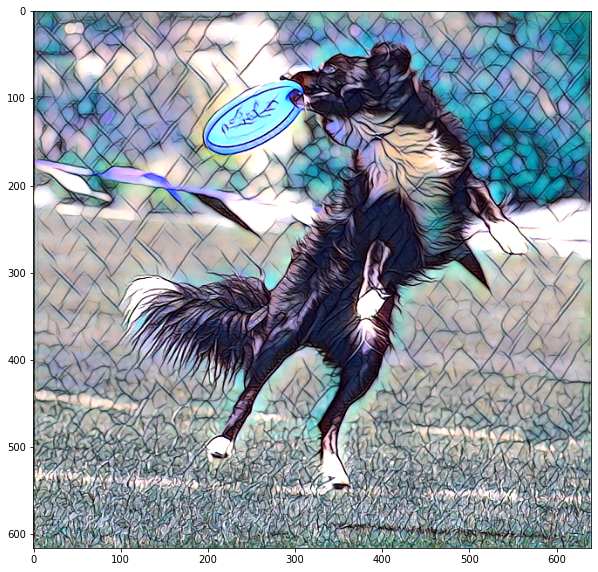

In [185]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(15)
plt.imshow(img, vmin=0, vmax=256)
